# EE798 HW1

In [460]:
from scipy.linalg import toeplitz, dft, inv, eigvals, eig, kron
from scipy.signal import convolve2d, convolve
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt 

## Q4 a

In [467]:
def linear_conv_mat(h:np.array,output_size):
    L = h.size
    h_ex = np.zeros(output_size)
    h_ex[0:L] = h
    first_row = np.roll(np.flip(h_ex),1)
    return toeplitz(h_ex.T,first_row[0:(output_size-L+1)]) # H + X - 1 = output_size

### Demonstration 

In [468]:
h = np.array([1,2,3,4,5])
H = linear_conv_mat(h,8)
H


array([[1., 0., 0., 0.],
       [2., 1., 0., 0.],
       [3., 2., 1., 0.],
       [4., 3., 2., 1.],
       [5., 4., 3., 2.],
       [0., 5., 4., 3.],
       [0., 0., 5., 4.],
       [0., 0., 0., 5.]])

### Verification 

In [469]:
x = np.random.randint(0,10,(8))
res = np.convolve(x,h)
H = linear_conv_mat(h,res.size)
res2 = np.matmul(H,x.T)
assert np.array_equal(res,res2)

x = np.random.randint(0,150,(32))
res = np.convolve(x,h)
H2 = linear_conv_mat(h,res.size)
res2 = np.matmul(H2,x.T)
assert np.array_equal(res,res2)

print('All tests are success!')

All tests are success!


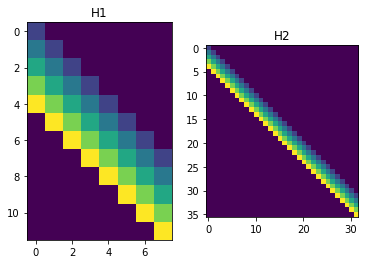

In [470]:
plt.subplot(1,2,1)
plt.imshow(H)
plt.title("H1")
plt.subplot(1,2,2)
plt.title("H2")
plt.imshow(H2)

## Q4 b 

### The circular convolution should be of length $$N = L_x + L_y - 1$$ to obtain linear convolution.

### The sequences $\hat{h} \ and \ \hat{x}$ are zero-padded version of sequences $h \ and \ x$ to the length of the linear convolution. This relationship is hidden inside the fft implementation, which automatically pads zero to the sequence if the FFT points N is larger than length of the sequence L.

In [471]:
def cconv(x:np.array, y:np.array, N:int):
    return np.round(np.real(ifft(np.multiply(fft(x,N),fft(y,N)))),3)


In [472]:
x = [0,1,2]
y = [4,5,6]
print(np.convolve(x,y))
cconv(x,y,5)

[ 0  4 13 16 12]


array([-0.,  4., 13., 16., 12.])

Verification

In [473]:
x = np.random.randint(0,5,(5))
y = np.random.randint(0,5,(4))
N = 8
res = cconv(x,y,N)
print("X = ",x,"\nY = ",y)
print("Linear convolution: ", np.convolve(x,y))
print("Circular convolution with N =", N, ":", res)
N = 6
res = cconv(x,y,N)
print("Circular convolution with N =", N, ":", np.round(res,2))


X =  [0 4 4 1 0] 
Y =  [3 3 1 3]
Linear convolution:  [ 0 12 24 19 19 13  3  0]
Circular convolution with N = 8 : [ 0. 12. 24. 19. 19. 13.  3. -0.]
Circular convolution with N = 6 : [ 3. 12. 24. 19. 19. 13.]


## Q4 c

### The implementation is based on the transformation of basis vectors of $\mathbb{R}^{N}$ where transform is the circular convolution.

In [474]:
def  cconvmtx(h:np.array, N:int):
    I = np.eye(N)
    for i in range(N):
        I[:,i] = np.round(cconv(h,I[:,i].T,N).T,3)
    return I

In [475]:
N = 1024
Max = 10
for trial in range(10): # Number of test cases
    h = np.random.randint(0,Max,N)
    x = np.random.randint(0,Max,N)
    res = cconv(x,h,N)
    H = cconvmtx(h,N)
    res2 = np.matmul(H,x)
    assert np.sum(np.isclose(res,res2)) == res.size # np.array_equal sometimes outputs False due to precision errors
print("All tests are success!")


All tests are success!


## Q4 d
### Verification 
* N values are swept from 4 to 64 and every case is asserted. 

In [476]:
A = dft(5)
B = inv(A)
C = A.conj()/5
np.sum(np.isclose(B,C)) == B.size


True

In [477]:
for N in range(4,64):
    h = np.random.randint(0,12,N)
    x = np.random.randint(0,12,N)
    F = dft(N)
    X = np.matmul(F,x)
    H = np.matmul(F,h)
    res = np.matmul(inv(F),np.multiply(X,H))
    res2 = cconv(x,h,N)
    assert np.sum(np.isclose(res,res2)) == res.size # np.array_equal may output False due to precision errors
print("All tests are success!")

All tests are success!


## Q4 e

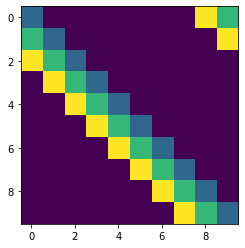

In [478]:
N = 10
H = cconvmtx([1,2,3],N)
plt.imshow(H)

### Verification 

All tests are success!


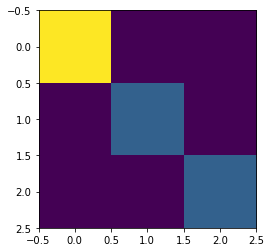

In [481]:
for trial in range(20):
    N = np.random.randint(0,5,1).item()
    h = np.random.randint(0,100,N)
    H = cconvmtx(h,N)
    F = dft(N)
    f_H = np.matmul(F,h)
    FCFH = F.dot(H).dot(F.conj().transpose())/N
    assert np.sum(np.isclose(FCFH, np.diag(f_H))) == FCFH.size
print("All tests are success!")
plt.imshow(np.abs(FCFH))

### First column experiment  

In [482]:
first_col = H[:,0]
FIRST_COL = np.matmul(F,first_col)
assert np.sum(np.isclose(FIRST_COL, f_H)) == FIRST_COL.size
print("All tests are success!")


All tests are success!


### Eigen Decomposition 

In [483]:
[E,P] = eig(H)
E

array([ 87. +0.j        , -24.+12.12435565j, -24.-12.12435565j])

In [484]:
np.round(FCFH)

array([[ 87. +0.j,  -0. +0.j,   0. +0.j],
       [ -0. -0.j, -24.-12.j,   0. -0.j],
       [  0. -0.j,   0. +0.j, -24.+12.j]])

[[-0.577+0.j   0.577+0.j   0.577-0.j ]
 [-0.577+0.j  -0.289-0.5j -0.289+0.5j]
 [-0.577+0.j  -0.289+0.5j -0.289-0.5j]]

 [13 44 30] 



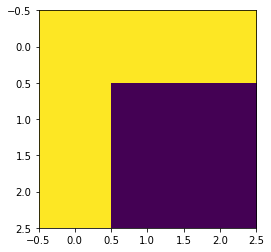

In [485]:
print(np.round(P,3))
print("\n",h,"\n")
plt.imshow(np.abs(np.round(P,1)))

In [486]:
np.round(dft(N)/np.sqrt(N),3)

array([[ 0.577+0.j ,  0.577+0.j ,  0.577+0.j ],
       [ 0.577+0.j , -0.289-0.5j, -0.289+0.5j],
       [ 0.577+0.j , -0.289+0.5j, -0.289-0.5j]])

# Q5 a

In [487]:
def sepconv2(X:np.array, h1:np.array, h2:np.array):
    X = convolve(X,h1)
    return convolve(X,h2)

In [488]:
from skimage import data
X = data.camera()
N1 = 5
N2 = 9
for trial in range(20):
    l1 = np.random.randint(-100,100,N1)
    l2 = np.random.randint(-100,100,N2)
    h1 = np.array(l1)
    h2 = np.array(l2)
    h1 = np.reshape(h1,(len(h1),1))
    h2 = np.reshape(h2,(len(h2),1)).T
    res = sepconv2(X,h1,h2)
    res2 = convolve2d(X, np.matmul(h1,h2))
    assert np.sum(np.isclose(res,res2)) == res.size # np.array_equal may output False due to precision errors
print("All tests are success!")

All tests are success!


# Q5 b

In [530]:
def sepconv2mtx(L1:int, L2:int, h1:np.array, h2:np.array):
    Lh1 = h1.shape[0] # column vector
    Lh2 = h2.shape[1] # row vector
    output1 = Lh1 + L1 - 1 
    output2 = Lh2 + L2 - 1
    H1 = linear_conv_mat(h1.T, output_size=output1)
    H2 = linear_conv_mat(h2, output_size=output2)
    return kron(H2,H1)

### Verification 

In [562]:
N = 32
X = np.random.randint(0,100,(N,N))
vecX = X.flatten(order="F").T
N1 = 5
N2 = 9
L1, L2 = X.shape[0], X.shape[1]
for trial in range(20):
    l1 = np.random.randint(-100,100,N1) / N1
    l2 = np.random.randint(-100,100,N2) / N2
    h1 = np.array(l1)
    h2 = np.array(l2)
    h1 = np.reshape(h1,(len(h1),1))
    h2 = np.reshape(h2,(len(h2),1)).T
    sepConv = sepconv2mtx(L1, L2, h1, h2)
    res = np.reshape(np.matmul(sepConv,vecX),(N1+L1-1,N2+L2-1), order="F")
    res2 = convolve2d(X,np.matmul(h1,h2))
    assert np.sum(np.isclose(res,res2)) == res.size # np.array_equal may output False due to precision errors
print("All tests are success!")

All tests are success!
